In [147]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.linalg import block_diag
from utils import get_form_initial_conditions
from unkkt import UNKKT
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

In [148]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 20 # Window size [min]
dynamic_model = SatelliteDynamics()

In [149]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [150]:
# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
# mm_newton.grad_tol = 1e-2
mm_newton.mm_tol = 1e-6
mm_newton.mm_max_iter = 20

In [151]:
# Fixed seed for reproducibility
# np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

Windows:   0%|          | 0/376 [00:00<?, ?it/s]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 23702999.414012246
Grad_L_norm = 169667379.991831

Iteration 1
L_norm = 121095.17749234693
Grad_L_norm = 2202011.1966142454

Iteration 2
L_norm = 7946.663878339466
Grad_L_norm = 150942.49580764957

Iteration 3
L_norm = 21295.048902960592
Grad_L_norm = 787472.8458114846

Iteration 4
L_norm = 607.9293230388097
Grad_L_norm = 7878.14227596689

Iteration 5
L_norm = 341.0735093565582
Grad_L_norm = 132182.17785852944

Iteration 6
L_norm = 83.25033636084095
Grad_L_norm = 728.4057711181558

Iteration 7
L_norm = 74.85335621097458
Grad_L_norm = 19787.113872674556

Iteration 8
L_norm = 69.80466915652052
Grad_L_norm = 12.563011149335452

Iteration 9
L_norm = 69.79987502390739
Grad_L_norm = 7.746861969679992

STOP on Iteration 10
L_norm = 69.79987421901568
Grad_L_norm = 0.0033302942087338467

Final position relative errors: 0.03370755956236147 m, 1.4046076000164385 m, 1.4375539313855368 m, 1.972971827281583 m
-------- Approx

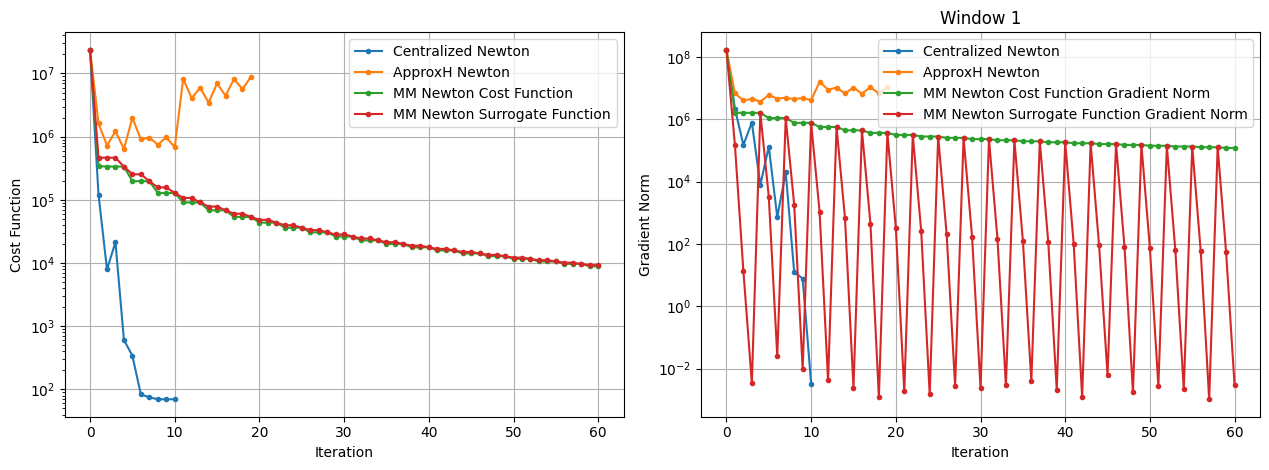


Windows:   0%|          | 1/376 [00:43<4:28:51, 43.02s/it]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 81.10898495010674
Grad_L_norm = 27697.74727355162

Iteration 1
L_norm = 72.15316459650872
Grad_L_norm = 2121.6778880409665

Iteration 2
L_norm = 72.08997138446844
Grad_L_norm = 2.144370394207568

STOP on Iteration 3
L_norm = 72.0899629323276
Grad_L_norm = 0.009699642881560703

Final position relative errors: 0.06109844322578713 m, 4.854280908494062 m, 3.1025376637345805 m, 3.467585993783582 m
-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 9812982.363149032
Gradient norm: 9645897.928316487
Global relative error: 2062.2510996913525
Position relative errors: 1.6895301550791988 m, 600.2094944438992 m, 1286.8281682110576 m, 1495.527330031771 m

Iteration 1
Cost function: 8570066.985798059 (-12.67%)
Gradient norm: 6451388.229906048 (-33.12%)
Global relative error: 3118.1930913181077 (51.20%)
Position relative errors: 1.2111501091997852 m, 293.0094940761692 m, 1710.241687312961 m, 2590.8

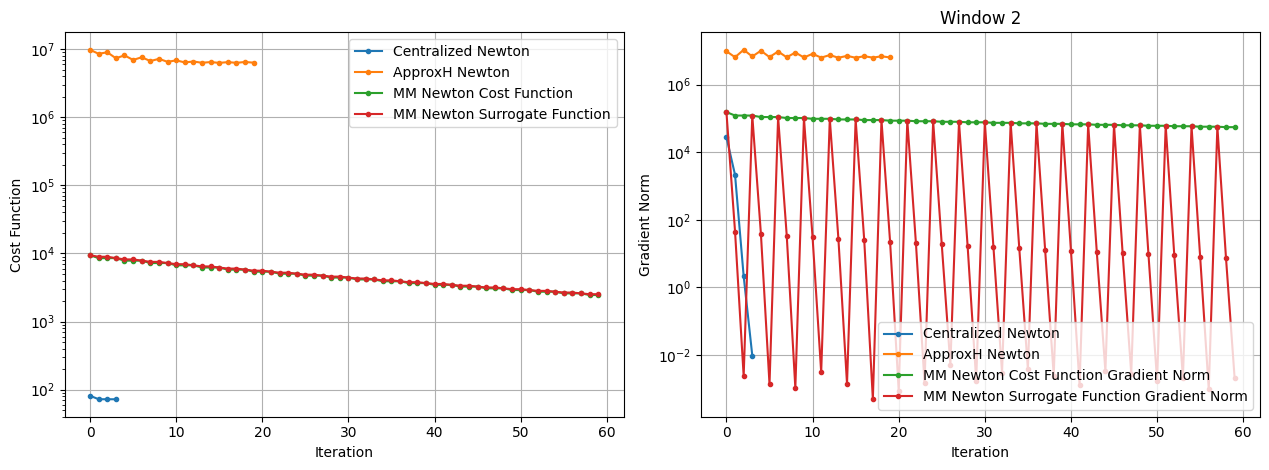


Windows:   1%|          | 2/376 [01:23<4:18:12, 41.42s/it]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 78.62552753576861
Grad_L_norm = 13514.91122250033

Iteration 1
L_norm = 71.80179025083031
Grad_L_norm = 6642.008493814342

Iteration 2
L_norm = 71.01406692151643
Grad_L_norm = 211.53308233167536

Iteration 3
L_norm = 71.00666101164451
Grad_L_norm = 8.255310062027561

STOP on Iteration 4
L_norm = 71.00665981856667
Grad_L_norm = 0.002575469752585566

Final position relative errors: 0.04885419258019973 m, 2.1159800909118855 m, 5.368853555540172 m, 5.118093944430266 m
-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 7453967.842971981
Gradient norm: 7689079.650596393
Global relative error: 3019.3441446630736
Position relative errors: 0.27900835861401446 m, 835.2232001898825 m, 1678.0487309229804 m, 2367.0387016573886 m

Iteration 1
Cost function: 9080096.255377872 (21.82%)
Gradient norm: 9778682.447947279 (27.18%)
Global relative error: 4709.413975376649 (55.97%)
Position relative errors

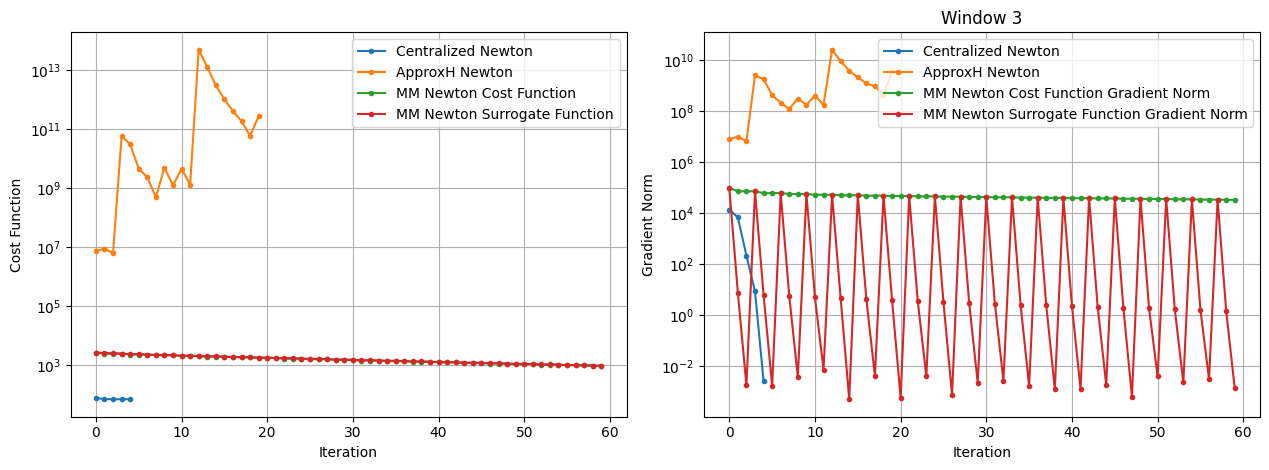


Windows:   1%|          | 3/376 [02:04<4:15:44, 41.14s/it]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 74.88031964814402
Grad_L_norm = 26697.49800233332

Iteration 1
L_norm = 72.16160450958245
Grad_L_norm = 130.29653345218028

STOP on Iteration 2
L_norm = 72.1578814895705
Grad_L_norm = 0.5274386243784827

Final position relative errors: 0.06907752141797546 m, 2.775376092522279 m, 9.744533613551967 m, 9.82424900801074 m
-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 324214698494.4478
Gradient norm: 4040577391.324525
Global relative error: 110887.62256616306
Position relative errors: 1565.0685184493918 m, 40418.8063487831 m, 56812.60219082488 m, 86210.18617392505 m

Iteration 1
Cost function: 51979885109.84523 (-83.97%)
Gradient norm: 1156029731.9789581 (-71.39%)
Global relative error: 72572.5312371173 (-34.55%)
Position relative errors: 1114.3417019735987 m, 46788.09117742959 m, 42700.97678534803 m, 35397.88759376334 m

Iteration 2
Cost function: 15225648179.387894 (-70.71%)
Gradien

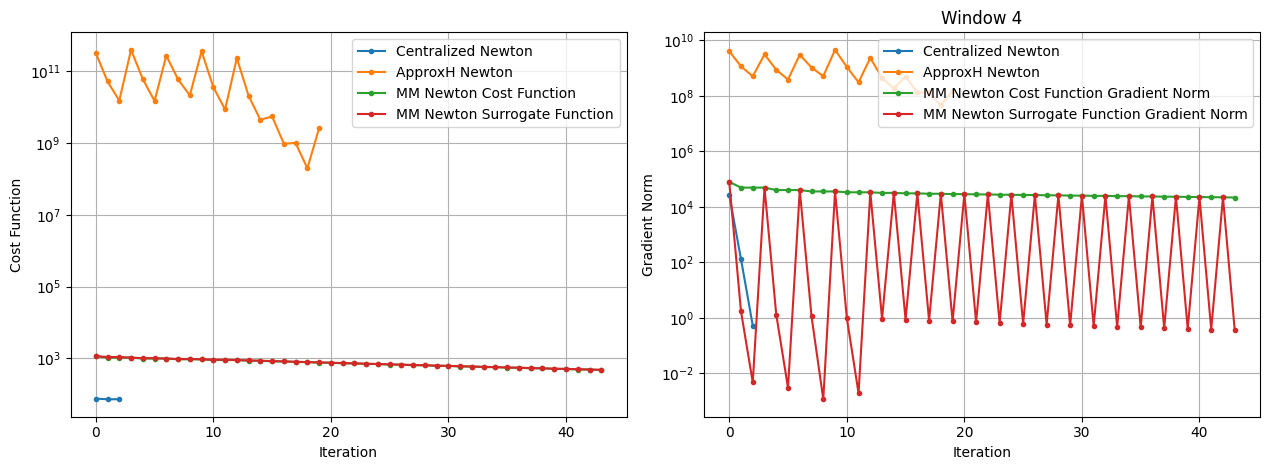


Windows:   1%|          | 4/376 [02:35<3:50:46, 37.22s/it]

-------- Centralized Newton --------
Before applying the algorithm
L_norm = 77.35084245152454
Grad_L_norm = 29376.423573657798

Iteration 1
L_norm = 74.19257833760419
Grad_L_norm = 75.54834164336673

STOP on Iteration 2
L_norm = 74.19087228247305
Grad_L_norm = 0.005223871430966669

Final position relative errors: 0.05563518470363382 m, 4.577371921052415 m, 14.347381143250178 m, 15.875332715219944 m
-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 2190148025.6025906
Gradient norm: 173028013.63786155
Global relative error: 18216.16272211192
Position relative errors: 76.17095438986121 m, 7552.885135651519 m, 15378.748993484729 m, 6186.252436156195 m

Iteration 1
Cost function: 228258620.09364423 (-89.58%)
Gradient norm: 85162816.09276544 (-50.78%)
Global relative error: 4442.570024518059 (-75.61%)
Position relative errors: 56.40707313950616 m, 2532.007949617398 m, 1805.5748130342756 m, 3172.0403364215695 m

Iteration 2
Cost function: 178323792234.7193 (78023.5


MC runs:   0%|          | 0/1 [02:48<?, ?it/s]            

STOP on Iteration 1
Cost function = 449.9899568380603 (-1.80%)
Gradient norm = 0.2559137338654845 (-100.00%)
Global relative error = 8.876676370686068 (1.14%)
Final position relative errors: 0.06794338095689409 m, 3.1126016691765805 m, 8.218958906420202 m, 1.244114088936252 m


Majorization-Minimization Iteration 7


KeyboardInterrupt: 

In [152]:
# Main execution loop
for m in tqdm(range(M), desc="MC runs", leave=True):
    # Observations
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

    # Estimate the state
    X_est_unkkt = X_initial + initial_dev
    X_est_approx_newton = X_initial + initial_dev
    X_est_mm = X_initial + initial_dev
    for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
        print("-------- Centralized Newton --------")
        X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n : n + W])
        print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n] - X_est_unkkt[18:21])} m")
        print("-------- ApproxH Newton --------")
        X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n : n + W], X_true[:, :, n])
        print("-------- MM Newton --------")
        X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n : n + W], X_true[:, :, n])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

        # First subplot - Cost function values
        ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
        ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
        ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
        ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Cost Function')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        # Second subplot - Gradient norm values
        ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
        ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
        ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
        ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.legend()

        plt.title(f'Window {n + 1}')
        plt.tight_layout()
        plt.show()
        
        unkkt.cost_function_values = []
        unkkt.grad_norm_values = []
        approxh_newton.cost_function_values = []
        approxh_newton.grad_norm_values = []
        mm_newton.cost_function_values = []
        mm_newton.grad_norm_values = []
        mm_newton.surrogate_function_values = []
        mm_newton.surrogate_grad_norm_values = []
        
        X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
        X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
        X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)